<a href="https://colab.research.google.com/github/TrevorIkky/Simple-Audio-Recognition/blob/main/SAR(Simple_Audio_Recognition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental import preprocessing
import keras.losses as losses
import keras.optimizers as optimizers
import keras.callbacks as callbacks

from IPython import display

In [ ]:
speech_commands_dir = pathlib.Path("data/mini_speech_commands")
if not speech_commands_dir.exists():
  keras.utils.get_file(
      "mini_speech_commands.zip",
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data'
  )

182083584/182082353 [==============================] - 1s 0us/step


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(speech_commands_dir)))
commands = commands[commands != "README.md"]
print("Commands are: {}. Length is {}".format(commands, len(commands)))

Commands are: ['up' 'no' 'go' 'left' 'stop' 'down' 'yes' 'right']. Length is 8


In [ ]:
filenames = tf.io.gfile.glob(str(speech_commands_dir) + "/*/*")
filenames = tf.random.shuffle(filenames)
print("Total command samples:", len(filenames))
print("Total examples per label", len(tf.io.gfile.listdir(str(speech_commands_dir) + '/' + commands[0])))
print("Example filenames tensor:", filenames[0])

Total command samples: 8000
Total examples per label 1000
Example filenames tensor: tf.Tensor(b'data/mini_speech_commands/left/9acd0254_nohash_0.wav', shape=(), dtype=string)


In [ ]:
train_files = filenames[:6400]
validation_files = filenames[6400: 7200]
test_files = filenames[-800:]
print("Length of train files", len(train_files))
print("Length of validation files", len(validation_files))
print("Length of test files", len(test_files))

Length of train files 6400
Length of validation files 800
Length of test files 800


In [ ]:
def get_label_from_path(path):
  return tf.strings.split(path, os.sep)[-2]

In [ ]:
def get_audio_tensor(audio_binary):
  """ decode_wav returns audio tensor and sample rate
  audio_tensor.shape = (16000, 1 ) after squeeze  shape = (16000, )"""
  audio_tensor, _ = tf.audio.decode_wav(audio_binary) 
  return tf.squeeze(audio_tensor, axis=-1)
#get_audio_tensor(tf.io.read_file(train_files[40]))

In [ ]:
def get_audio_tensor_and_label(audio_path):
  audio_binary = tf.io.read_file(audio_path)
  return get_audio_tensor(audio_binary), get_label_from_path(audio_path)

In [ ]:
def get_waveform_ds(dataset):
  file_paths_ds = tf.data.Dataset.from_tensor_slices(dataset)
  return file_paths_ds.map(get_audio_tensor_and_label, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
waveform_ds = get_waveform_ds(train_files)

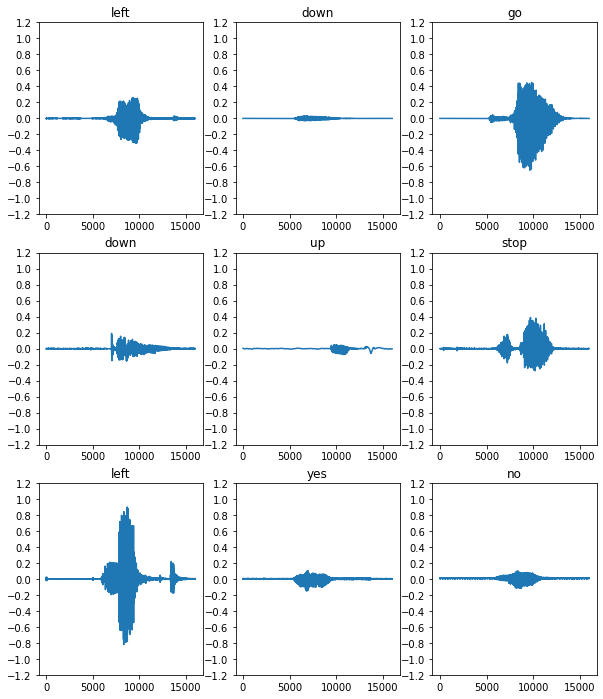

In [ ]:
def graph_waveform_and_label(waveform_ds):
  rows = 3
  cols = 3
  n = rows * cols
  fig , axes = plt.subplots(rows, cols, figsize=(10, 12))
  for i, (audio, label) in enumerate(waveform_ds.take(n)):
    """ i // cols  Divide the current index by cols & ignore reminder"""
    ax = axes[i // cols][i % cols]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.4, 0.2))
    ax.set_title(label.numpy().decode('utf-8'))
  plt.show()
  
graph_waveform_and_label(waveform_ds)

In [ ]:
def get_spectrogram(audio_t):
  """tf.signal.stft returns the magnitude & phase of the audio
  tf.abs(tf.signal.stft) keeps the magnitude only"""
  padding = tf.zeros([16000] - tf.shape(audio_t), dtype=tf.float32)
  f32_waveform = tf.cast(audio_t, dtype=tf.float32)
  padded_waveform = tf.concat([f32_waveform, padding], axis=0)
  #print("STFT shape: ", tf.signal.stft(padded_waveform, frame_length=255, frame_step=128).shape)
  return tf.abs(tf.signal.stft(padded_waveform, frame_length=255, frame_step=128))

for audio, label in waveform_ds.take(1):
  spectrogram = get_spectrogram(audio)
  waveform_shape = audio.shape
  audio_label = label.numpy().decode('utf-8')

print("Waveform shape: ", waveform_shape)
print("Spectrogram shape: ", spectrogram.shape)
print("Audio label: ", audio_label)
print("Audio sample: \n ")
display.display(display.Audio(audio, rate=16000))

Waveform shape:  (16000,)
Spectrogram shape:  (124, 129)
Audio label:  left
Audio sample: 
 


In [ ]:
def plot_spectrogram(spectrogram_v, ax, label=None):
  """Find the transpose to that time can be represented
  in the X-axis. Shape of spectrogram is 124, 129 meaning that 
  129 represents the signals that make up the original signals. We have 124
  of such signals. 129 , 124 means that we have 124 timesteps each timestep 
  representing a signal decomposition from tf.signal.stft"""
  l = np.log(spectrogram_v.T)
  X = np.linspace(0, np.size(spectrogram_v), num=l.shape[1], dtype=int)
  Y = range(l.shape[0])
  if not label == None:
    ax.set_title(label)
  ax.pcolormesh(X, Y, l)



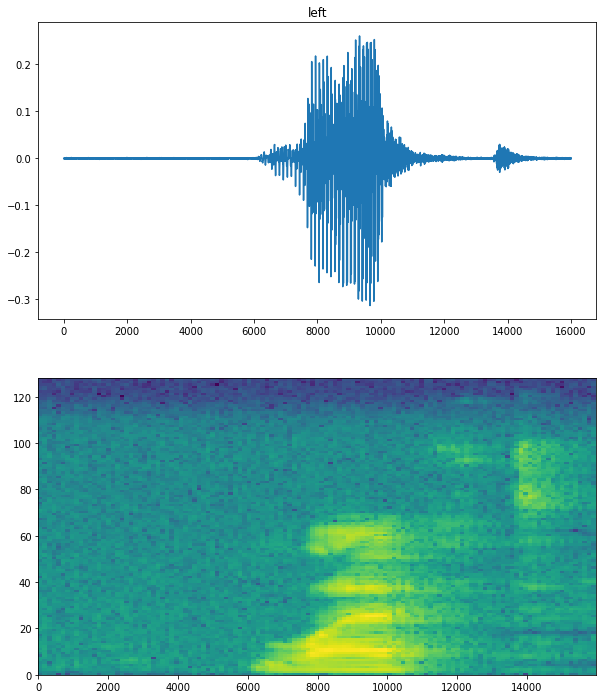

In [ ]:
_, axes = plt.subplots(2, figsize=(10,12))
"""Plot sample rate values"""
axes[0].plot(np.arange(audio.shape[0]), audio.numpy())
axes[0].set_title(label.numpy().decode('utf-8'))
plot_spectrogram(spectrogram.numpy(), axes[1])
plt.show()

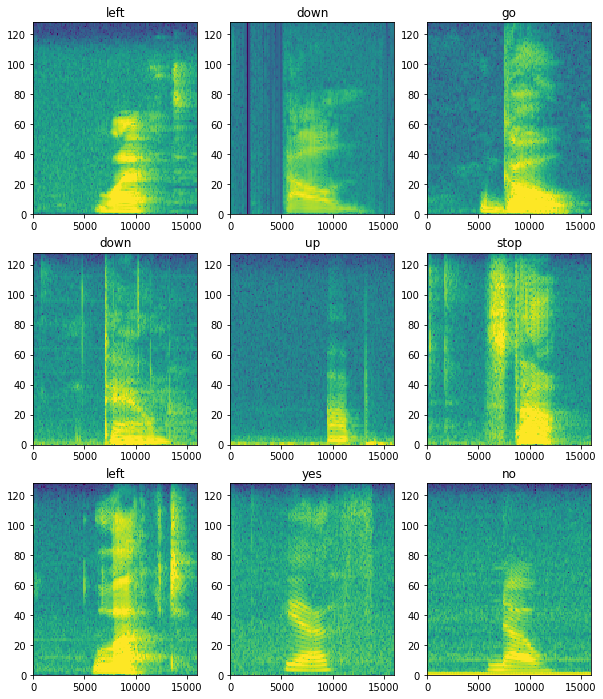

In [ ]:
def plot_spectrograms(waveforms):
  rows = 3
  cols = 3
  n = rows * cols
  _, axes = plt.subplots(3, 3, figsize=(10, 12))
  for i, (audio, label) in enumerate(waveforms.take(n)):
      spectrogram = get_spectrogram(audio)
      ax = axes[i // cols][i % cols]
      plot_spectrogram(
          np.clip(spectrogram.numpy(), keras.backend.epsilon(), 1 - keras.backend.epsilon()),
          ax, label=label.numpy().decode('utf-8'))
  plt.show()

plot_spectrograms(waveform_ds)

In [ ]:
def get_spectrogram_and_label_id(audio_path):
  audio, label = get_audio_tensor_and_label(audio_path)
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, axis=-1)
  return spectrogram, tf.argmax(commands == label)

#s, l = get_spectrogram_and_label_id(train_files[2])

In [ ]:
def preprocess_audio_files(files, batch_size=64):
  """Create a tf.data.Dataset object from audio file paths and apply 
  get_spectrogram_and_label_id. Batch, cache and prefetch the ds"""
  ds = tf.data.Dataset.from_tensor_slices(files)
  ds = ds.map(get_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)
  return ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

train_ds = preprocess_audio_files(train_files)
validation_ds = preprocess_audio_files(validation_files)
test_ds = preprocess_audio_files(test_files)

In [ ]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape

print("Model Input Shape: ", input_shape[1:])
inputs = keras.layers.Input(shape=input_shape[1:])
x = preprocessing.Resizing(32, 32)(inputs)
normalization = preprocessing.Normalization()
normalization.adapt(train_ds.map(lambda x, _: x))

x = keras.layers.Conv2D(32, 3, activation=tf.nn.relu)(x)
x = keras.layers.Conv2D(64, 3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation=tf.nn.relu)(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(len(commands))(x)

model = keras.Model(inputs=inputs, outputs=x)
model.compile(optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.summary()


Model Input Shape:  (124, 129, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 124, 129, 1)]     0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)      

In [ ]:
EPOCHS = 50
history = model.fit(train_ds, validation_data=validation_ds, epochs=EPOCHS, callbacks=[callbacks.EarlyStopping(patience=5)])

Epoch 1/50
100/100 [==============================] - 3s 27ms/step - loss: 1.9127 - accuracy: 0.2908 - val_loss: 1.3264 - val_accuracy: 0.5462
Epoch 2/50
100/100 [==============================] - 1s 7ms/step - loss: 1.2783 - accuracy: 0.5494 - val_loss: 0.9316 - val_accuracy: 0.6712
Epoch 3/50
100/100 [==============================] - 1s 7ms/step - loss: 0.9771 - accuracy: 0.6581 - val_loss: 0.7585 - val_accuracy: 0.7125
Epoch 4/50
100/100 [==============================] - 1s 7ms/step - loss: 0.7851 - accuracy: 0.7281 - val_loss: 0.6683 - val_accuracy: 0.7475
Epoch 5/50
100/100 [==============================] - 1s 7ms/step - loss: 0.6604 - accuracy: 0.7697 - val_loss: 0.6140 - val_accuracy: 0.7763
Epoch 6/50
100/100 [==============================] - 1s 7ms/step - loss: 0.5766 - accuracy: 0.8004 - val_loss: 0.5632 - val_accuracy: 0.8050
Epoch 7/50
100/100 [==============================] - 1s 7ms/step - loss: 0.5089 - accuracy: 0.8173 - val_loss: 0.5529 - val_accuracy: 0.8037
Epoch

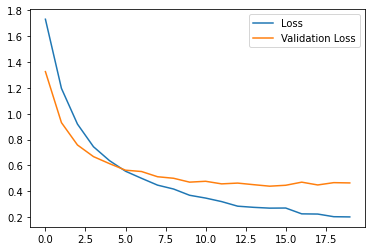

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["Loss", "Validation Loss"])

In [ ]:
"""Prediction shape is 64,8 and the label shape is 64,
Meaning 64 labels for the batch consisting of 64 samples
Same logic applies to the prediction shape. Therfore in each
Iteration we only access the 0 index from the arrays returned by the
predictions"""
for (spectrogram, label) in test_ds.take(10):
  prediction = model.predict(spectrogram)
  print("Command is: ", commands[ label.numpy()[0]])
  print("Predicted command is: ", commands[ np.argmax(tf.nn.softmax(prediction[0]).numpy())])

Command is:  yes
Predicted command is:  yes
Command is:  stop
Predicted command is:  stop
Command is:  yes
Predicted command is:  yes
Command is:  no
Predicted command is:  no
Command is:  left
Predicted command is:  left
Command is:  left
Predicted command is:  left
Command is:  yes
Predicted command is:  yes
Command is:  stop
Predicted command is:  stop
Command is:  no
Predicted command is:  no
Command is:  yes
Predicted command is:  yes
